<a href="https://colab.research.google.com/github/jucardozo/tp-2-Redes-Neuronales/blob/main/TP2_Segmentaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/DatasetRedesNeuronales/PhC-C2DH-U373.zip

Archive:  drive/MyDrive/DatasetRedesNeuronales/PhC-C2DH-U373.zip
   creating: PhC-C2DH-U373/
   creating: PhC-C2DH-U373/01/
  inflating: PhC-C2DH-U373/01/t000.tif  
  inflating: PhC-C2DH-U373/01/t001.tif  
  inflating: PhC-C2DH-U373/01/t002.tif  
  inflating: PhC-C2DH-U373/01/t003.tif  
  inflating: PhC-C2DH-U373/01/t004.tif  
  inflating: PhC-C2DH-U373/01/t005.tif  
  inflating: PhC-C2DH-U373/01/t006.tif  
  inflating: PhC-C2DH-U373/01/t007.tif  
  inflating: PhC-C2DH-U373/01/t008.tif  
  inflating: PhC-C2DH-U373/01/t009.tif  
  inflating: PhC-C2DH-U373/01/t010.tif  
  inflating: PhC-C2DH-U373/01/t011.tif  
  inflating: PhC-C2DH-U373/01/t012.tif  
  inflating: PhC-C2DH-U373/01/t013.tif  
  inflating: PhC-C2DH-U373/01/t014.tif  
  inflating: PhC-C2DH-U373/01/t015.tif  
  inflating: PhC-C2DH-U373/01/t016.tif  
  inflating: PhC-C2DH-U373/01/t017.tif  
  inflating: PhC-C2DH-U373/01/t018.tif  
  inflating: PhC-C2DH-U373/01/t019.tif  
  inflating: PhC-C2DH-U373/01/t020.tif  
  inflating: Ph

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

In [4]:
from PIL import Image

# Cargo Train y Val

Train será aumentado

In [5]:
train_path = Path("PhC-C2DH-U373/01/").glob("**/*tif")
val_path = Path("PhC-C2DH-U373/02/").glob("**/*tif")

In [6]:
train_images = list()
train_masks = list()
for file in train_path:
    train_images.append(np.array(Image.open(file)).reshape(1,520,696))
    train_masks.append(np.array(Image.open(f'PhC-C2DH-U373/01_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

val_images = list()
val_masks = list()

for file in val_path:
    val_images.append(np.array(Image.open(file)).reshape(1,520,696))  #me permite concatenar
    val_masks.append(np.array(Image.open(f'PhC-C2DH-U373/02_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

In [7]:
train_images = np.vstack(train_images)/255
train_masks = 1*(np.vstack(train_masks) > 0)  #0 es fondo , 1 significa la celula 1 y  asi , detector binario
val_images = np.vstack(val_images)/255  # normalizo
val_masks = 1*(np.vstack(val_masks) >0 )

# Imágenes de train sin aumentar

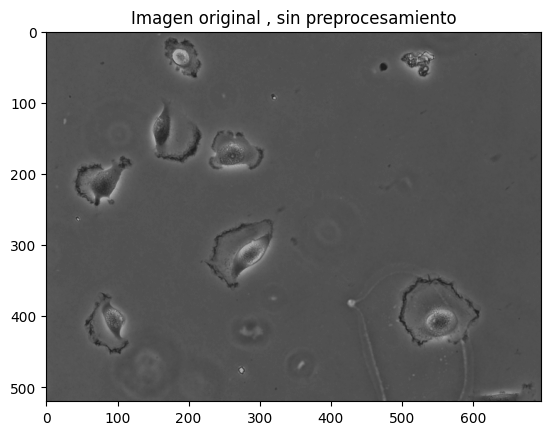

In [8]:
idx =0
plt.title("Imagen original , sin preprocesamiento")
plt.imshow(train_images[idx], vmin=0, vmax=1, cmap="gray")
plt.show()

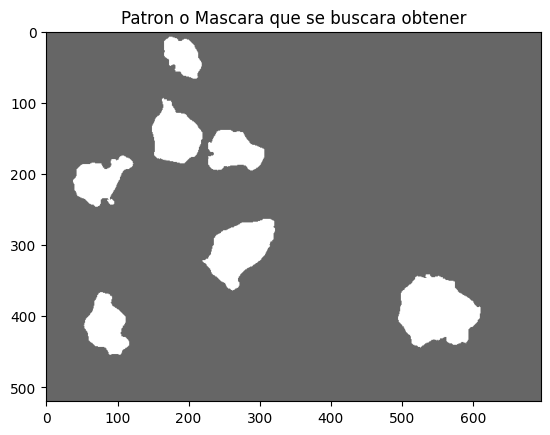

In [9]:
idx =0
plt.title("Patron o Mascara que se buscara obtener")
plt.imshow(train_masks[idx], vmin=0, vmax=1, cmap="gray",alpha=0.6)
plt.show()

# Armo datasets de tensorflow y aumento

Para mantener sincronizada la aumentación entre la imagen y la máscara, armo una entrada de 4 canales que de descompondrán durante el entrenamiento.

In [10]:
x_train = np.stack((train_images, train_masks ),axis=-1)
x_val = np.stack((val_images, val_masks ),axis=-1)

In [11]:
x_train[0,:,:,0].max()

0.7294117647058823

In [12]:
len(x_train)

115

In [13]:
len(val_masks)

115

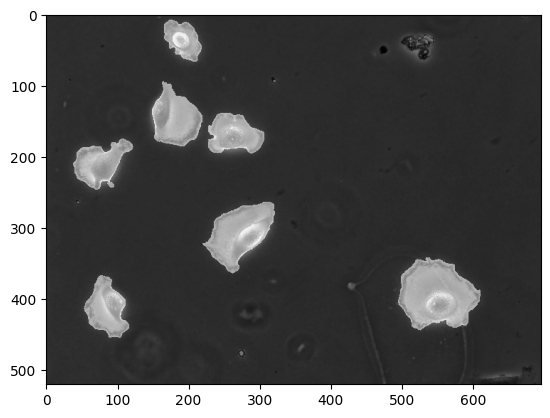

In [14]:
plt.imshow(x_train[0,:,:,0], cmap="gray")
plt.imshow(x_train[0,:,:,1], cmap="gray", alpha = 0.5)

In [15]:
from tensorflow.keras.models import Sequential

# Armo una red mínima fully convolutional con Atrous Convolutions

Es un red convolucional que se caracteriza por tener todas sus entradas conectadas , por lo tanto no es necesario aclararle la cantidad de neuronas en la capa de entrada. Ademas , se puede observar que al utilizr a capas completas la informacion espacial se mantiene hasta llegar a la salida de la misma, por eso la red recibira como entrada una imagen y a la salida obtendremos una mascara del mismo tamaño. Tenemos una tasa de dilatacion que nos permitira aumentar el campo perceptual sin aumentar la cantidad de parametros de la misma.
Como defecto , podemos de decir que esta red basica, tendra un costo de computacion muy alto, ya que nunca tenemos una capa de pooling para que se pueda reducir la dimensionalidad.


##MODELO CONVOLUCIONAL COMPLETAMENTE CONECTADO.

In [16]:
filters = 16 #los filtros deberian ir subiendo de dos en dos
kernel_size = 10
def get_red_seg():
    return Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1, input_shape = (None,None,1)),  #no es necesario indicarle el tamaño de la imagen xq es fully connection
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 2),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 4),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 8),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1),
        tf.keras.layers.Conv2D(1, kernel_size,padding="same", activation = "sigmoid", dilation_rate = 1) #necesito clasificar binariamente ,por eso la sigmoide
    ])


# Armo la red de preprocesamiento para hacer aumentación en la GPU que no tengo

 se hace el dataumentation con el fin de proporcionar mas cantidad de datos a nuestra red . Se recorta imagenes, se flipea tanto horizontal como vertical, tambien se zoom , traslaciones y rotaciones.

In [17]:
def get_preproc():
    return  tf.keras.Sequential([
        tf.keras.layers.RandomCrop(512,512),        #esta capa recorta aleatoriamente un imagen de entrada obteniendo una de 512X512
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'), # flipea aletoreamente de modo vertical o modo horinzontal.
        #tf.keras.layers.RandomZoom((-0.1,0.3)),
        #tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        #tf.keras.layers.RandomRotation((0,1)),
        #tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

def get_preproc_val():
    return  tf.keras.Sequential([
        tf.keras.layers.CenterCrop(512,512), # se realiza un recorte de la imagen , pero a diferencia de random crop, esta lo hace a partir del centro
        ])

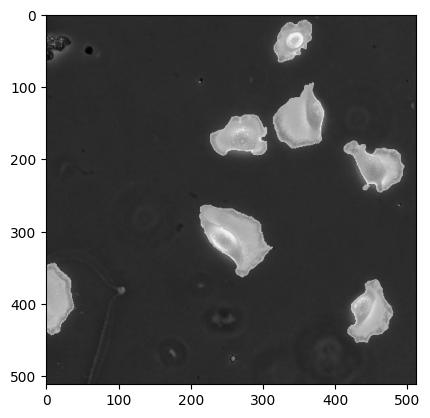

In [18]:
preproc = get_preproc()
aux_elem = preproc(x_train[0])
plt.imshow(aux_elem[:,:,0], cmap="gray")
plt.imshow(aux_elem[:,:,1], cmap="gray", alpha = 0.5)

Podemos observar que efectivamente estamos realizando una aumento en la cantidad de datos , pasamos de 115 a 512

In [ ]:
len(aux_elem)

512

##COEFICIENTE DE DICE
Se utiliza como metrica para saber que tan acertado esta nuestro patron con su contraparte verdadera .
Se puede calcular como 2[(AnMask)/(A+Mask)].

In [19]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [23]:
class SegmentationModel(Model):
    def __init__(self, red_preproc, red_segmentacion, red_preproc_val):
        super().__init__()
        self.red_segmentacion = red_segmentacion
        self.red_preproc = red_preproc
        self.red_preproc_val = red_preproc_val
        self.loss_tracker = metrics.Mean(name="loss")
        self.dice = False


    def call(self, inputs):
        #img_mask = self.red_preproc = red_preproc(inputs)
        return self.red_segmentacion(inputs[:,:,:1])  #me quedo solo con el canal cero

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape: #me permite guardar info valida pa poder calcular el gradiente.
            data_aug = self.red_preproc(data)#DURANTE EL ENTRENAMIENTO.
            loss = self._compute_loss(data_aug)
            #print(K.mean(loss))

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.red_segmentacion.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.red_segmentacion.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        data_preproc = self.red_preproc_val(data)
        loss = self._compute_loss(data_preproc)
        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        #aux = self.red_preproc(data)
        mask_out = self.red_segmentacion(data[:,:,:,:1])
        #print(mask_out.shape)
        #print(data[:,:,:,1:2].numpy())
        if self.dice == True:
            loss = dice_loss(data[:,:,:,1:2], mask_out)
        else:
            loss = tf.keras.losses.binary_crossentropy(data[:,:,:,1:2], mask_out) #calculamos la binarycross entre ls datos aumentados y la mascara
        return loss #tensor asociado a un grafo => puedo calcular el gradiente.

    # property
    # def metrics(self):
    #     # We need to list our metrics here so the `reset_states()` can be
    #     # called automatically.
    #     return [self.loss_tracker]

In [20]:
red_falopa = get_red_seg()

In [21]:
red_falopa.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    1616      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 105,681
Trainable params: 105,681
Non-tr

## Modelo COMPILACION Y ENTRENAMIENTO .
se arma el modelo, mediante una clase previamente creada. Recibe como parametros la funcion de preprocesamientos para los datos de entrenamiento, la funcion de preprocesamiento de los datos de validacion y ademas la red convolucional fully.

In [24]:
preproc= get_preproc()          #PREPROCESAMIENTO , EN PARTICULAR DATA AUMENTATION
preproc_val = get_preproc_val()
red_falopa = get_red_seg()      ## RED CONVOLUSIONAL
model = SegmentationModel(preproc, red_falopa,preproc_val)

In [25]:
model.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [26]:
len(x_val)

115

In [27]:
model.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
8/8 [==============================] - 74s 2s/step - loss: 0.6818 - val_loss: 0.6188
Epoch 2/100
8/8 [==============================] - 8s 1s/step - loss: 0.5378 - val_loss: 0.2565
Epoch 3/100
8/8 [==============================] - 8s 1s/step - loss: 0.3651 - val_loss: 0.1747
Epoch 4/100
8/8 [==============================] - 8s 1s/step - loss: 0.3476 - val_loss: 0.2444
Epoch 5/100
8/8 [==============================] - 8s 1s/step - loss: 0.3364 - val_loss: 0.1872
Epoch 6/100
8/8 [==============================] - 8s 1s/step - loss: 0.3453 - val_loss: 0.2155
Epoch 7/100
8/8 [==============================] - 8s 1s/step - loss: 0.3325 - val_loss: 0.1961
Epoch 8/100
8/8 [==============================] - 8s 1s/step - loss: 0.3385 - val_loss: 0.2059
Epoch 9/100
8/8 [==============================] - 8s 1s/step - loss: 0.3369 - val_loss: 0.1982
Epoch 10/100
8/8 [==============================] - 8s 1s/step - loss: 0.3294 - val_loss: 0.1968
Epoch 11/100
8/8 [====================

In [28]:
pred = red_falopa(x_val[0:1,:,:,0])
pred.shape

TensorShape([1, 520, 696, 1])

In [29]:
pred.numpy().max()

0.99586236

##SALIDA DEL MODELO

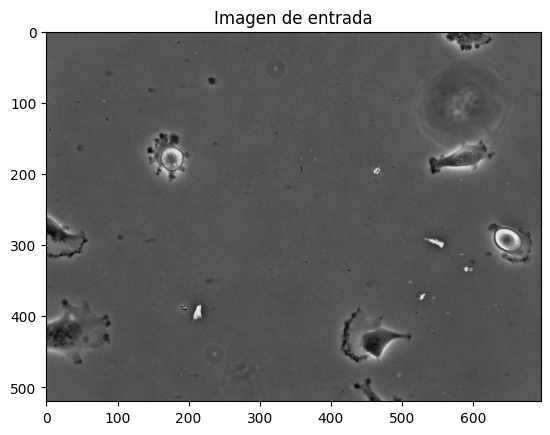

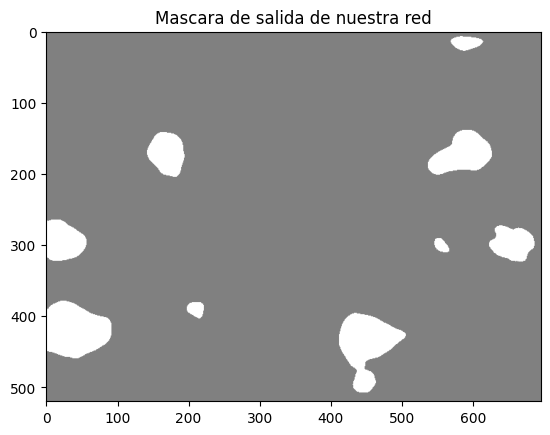

In [30]:
plt.title("Imagen de entrada")
plt.imshow(x_val[0,:,:,0], cmap="gray")
plt.show()
#plt.imshow(x_val[0,:,:,1], cmap="gray", alpha=0.5)
plt.title("Mascara de salida de nuestra red")
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5)
plt.show()

#MODELO U-NET
La arquitectura, a diferencia de la anterior , no consta con una red completamente conectada si no que tiene de dos partes principales: el "encoder" (codificador) y el "decoder" (decodificador). El encoder está compuesto por una serie de bloques convolucionales(conv_block)  que se utilizan para extraer características de la imagen de entrada.Estos bloques estan estan compuestos de dos capas convolucionales, dos capas de batch normalization y un dropout. Además éstos estarán seguidos generalmente por capas de pooling (por ejemplo, MaxPooling) para reducir la dimesionalidad.
El decoder utiliza capas de convolución transpuesta (también conocidas como capas de upsampling) para aumentar la resolución espacial de las características. Además, se realizan conexiones entre los niveles del encoder y del decoder mediante concatenación o sumas, lo que permite fusionar información de diferentes niveles de la red y preservar detalles contextuales.
Particularmente , la arquitectura en U propiamente dicha, se realiza con la función level_block que se encarga de crear los bloques convolucionales y unirnos mediantes una capa de pooling , si estamos en la parte del encoder, o con un upsampling si estamos en el decoder.

Es importante aclarar que como ultima capa de salida tenemos una capa con una funcion sigmoide, ya que esta nos va permitar escalar los valores a una probabilidad.

In [31]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D,Conv2DTranspose

In [32]:
img_shape = (512, 512, 1)
def conv_block(m, dim, acti, bn, res, do=0):#BLOQUE CONVOLUCIONAL.
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res): #ES EL ENCARGADO DE HACER EL DIAGRAMA DE LA UNET.
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [33]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)


In [34]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))
red_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_18[0][0]']              
                                )                                                             

In [35]:
model_unet.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
8/8 [==============================] - 50s 3s/step - loss: 0.6701 - val_loss: 0.6374
Epoch 2/100
8/8 [==============================] - 11s 1s/step - loss: 0.6087 - val_loss: 0.4642
Epoch 3/100
8/8 [==============================] - 11s 1s/step - loss: 0.4154 - val_loss: 0.1884
Epoch 4/100
8/8 [==============================] - 11s 1s/step - loss: 0.3791 - val_loss: 0.2799
Epoch 5/100
8/8 [==============================] - 14s 2s/step - loss: 0.3703 - val_loss: 0.2091
Epoch 6/100
8/8 [==============================] - 12s 1s/step - loss: 0.3539 - val_loss: 0.2197
Epoch 7/100
8/8 [==============================] - 12s 1s/step - loss: 0.3465 - val_loss: 0.2073
Epoch 8/100
8/8 [==============================] - 12s 1s/step - loss: 0.3475 - val_loss: 0.2176
Epoch 9/100
8/8 [==============================] - 12s 1s/step - loss: 0.3382 - val_loss: 0.2009
Epoch 10/100
8/8 [==============================] - 11s 1s/step - loss: 0.3245 - val_loss: 0.2068
Epoch 11/100
8/8 [===========

In [36]:
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])
pred.shape

TensorShape([1, 512, 512, 1])

In [37]:
pred.numpy().max()

0.99995875

##SALIDA DEL MODELO

In [38]:
print(dice_coef(aux[0:1,:,:,0], pred))



tf.Tensor(0.07215385, shape=(), dtype=float32)


In [39]:
print(dice_loss(aux[0:1,:,:,0], pred))

tf.Tensor(0.92784613, shape=(), dtype=float32)


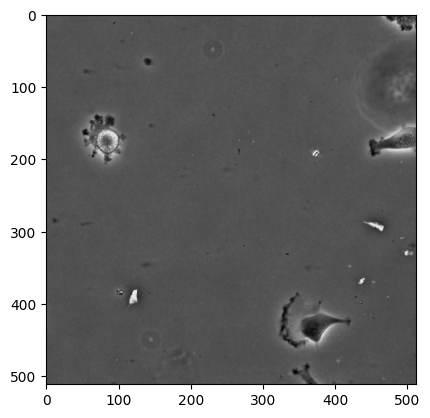

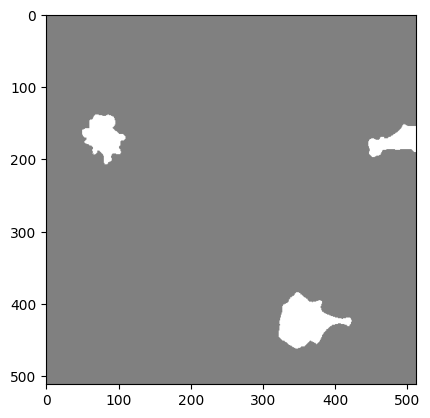

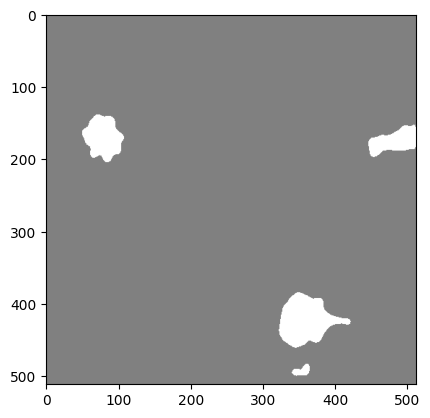

In [40]:
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha = 0.5)
plt.show()
plt.imshow(pred[0,:,:,0]>0.7, cmap="gray", alpha = 0.5)
plt.show()

#MODELO U-NET CON DROPOUT

In [50]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = 0.2,
    residual = True
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))
red_unet.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_156 (Conv2D)            (None, 512, 512, 16  160         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_157 (Conv2D)            (None, 512, 512, 16  2320        ['conv2d_156[0][0]']             
                                )                                                           

In [51]:
model_unet.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
5/8 [=================>............] - ETA: 3s - loss: 0.7466

ResourceExhaustedError: ignored